In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
from pytz import timezone

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show, plot_events_data
from utils.optimization import MyOptimizationProblem, convert_to_model_params, plot_optimization_params, plot_optimization_error, plot_compare, compute_metrics, estimate_polynomial_coefficient_bounds
from utils.data import get_events, get_sections, process_df, export_dataframe_to_latex, load_df as load_df_inner
from utils.sensitivity_analysis import describe_param_with_uniform_distribution, describe_param_with_log_uniform_distribution, describe_param_with_triangular_distribution, describe_param_with_normal_distribution, describe_param_with_truncated_normal_distribution, describe_param_with_log_normal_distribution, wrapped_model_function, create_problem_spec_and_sample, plot_sampled_distribuitions, evaluate_problem, analyze_time_step, analyze_problem, sobol_sensitivity_analysis_from_model_params_to_outputs, plot_sensitivity_analysis, plot_sensitivity_analysis_heatmaps, get_region_mean, plot_sensitivity_analysis_bars

import warnings
warnings.filterwarnings("ignore")

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/'
latex_tex_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/tex/'

# Data

In [2]:
def compute_df_soc(df, nominal_Q, inplace=False):
    """
    Compute the State of Charge (SOC) of a battery.

    Parameters:
        df (pd.DataFrame): DataFrame containing battery data.
        nominal_Q (float): Nominal capacity of the battery in Ampere-hours (Ah).
        inplace (bool, optional): If True, the SOC values are added to the input DataFrame `df`.
                                  Default is False.

    Returns:
        np.ndarray: Array containing the computed SOC values as a fraction of the nominal capacity.

    Notes:
        - The input DataFrame `df` is expected to contain a column named 'batt_Q' representing the battery charge.
        - The output SOC values are dimensionless fractions representing the battery's charge level relative to its nominal capacity.
        - If `inplace` is True, the computed SOC values are added as a new column 'batt_z' to the input DataFrame `df`.
    """
    SOC = df['batt_Q'].to_numpy() / nominal_Q

    if inplace:
        df['batt_z'] = SOC
    return SOC

def compute_df_capacity(df, nominal_Q, initial_SOC, inplace=False):
    """
    Compute the capacity of a battery based on cumulative integration of current over time.

    Parameters:
        df (pd.DataFrame): DataFrame containing battery data.
        nominal_Q (float): Nominal capacity of the battery in Ampere-hours (Ah).
        initial_SOC (float): Initial State of Charge (SOC) as a fraction of the nominal capacity.
        inplace (bool, optional): If True, the computed capacity values are added to the input DataFrame `df`.
                                  Default is False.

    Returns:
        np.ndarray: Array containing the computed capacity values in Ampere-hours (Ah).

    Notes:
        - The input DataFrame `df` is expected to contain columns 'batt_i' for battery current and 't' for time.
        - The output capacity values represent the remaining battery capacity after cumulative integration of current over time.
        - The input parameter `initial_SOC` is a dimensionless fraction representing the initial battery charge relative to its nominal capacity.
        - If `inplace` is True, the computed capacity values are added as a new column 'batt_Q' to the input DataFrame `df`.
    """
    from scipy.integrate import cumulative_trapezoid as cumtrapz

    time_hours = df['t'] / 3600.0  # Converts time in seconds to time in hours
    Q = (nominal_Q * initial_SOC) - cumtrapz(df['batt_i'], time_hours, initial=0)  # units: Amper-hour

    if inplace:
        df['batt_Q'] = Q
    return Q

def load_df(filename, start, end, resample_rule, rename_columns, print_columns, iqr_threshold, cutoff_freq, sampling_rate, order, nominal_Q, initial_SOC):
    df = load_df_inner(
        filename=filename,
        start=start,
        end=end,
        resample_rule=resample_rule,
        rename_columns=rename_columns,
        print_columns=print_columns,
        iqr_threshold=iqr_threshold,
        cutoff_freq=cutoff_freq,
        sampling_rate=sampling_rate,
        order=order,
    )

    compute_df_capacity(df, nominal_Q, initial_SOC, inplace=True)
    compute_df_soc(df, nominal_Q, inplace=True)

    return df

cell_amps_hour = 48
series_cells = 3
parallel_cells = 1
cell_voltage = 12
nominal_Q = parallel_cells * cell_amps_hour  # Capacity, in Amper-hour
initial_SOC = 0.99

Train size ≃ 0.60%
Test size ≃ 99.40%
section: Section D (Test) -> nans: 48000
section: Section E (Test) -> nans: 22800
section: Section F (Test) -> nans: 22520
section: Section F1 (Train) -> nans: 560
section: Section F2 (Test) -> nans: 900


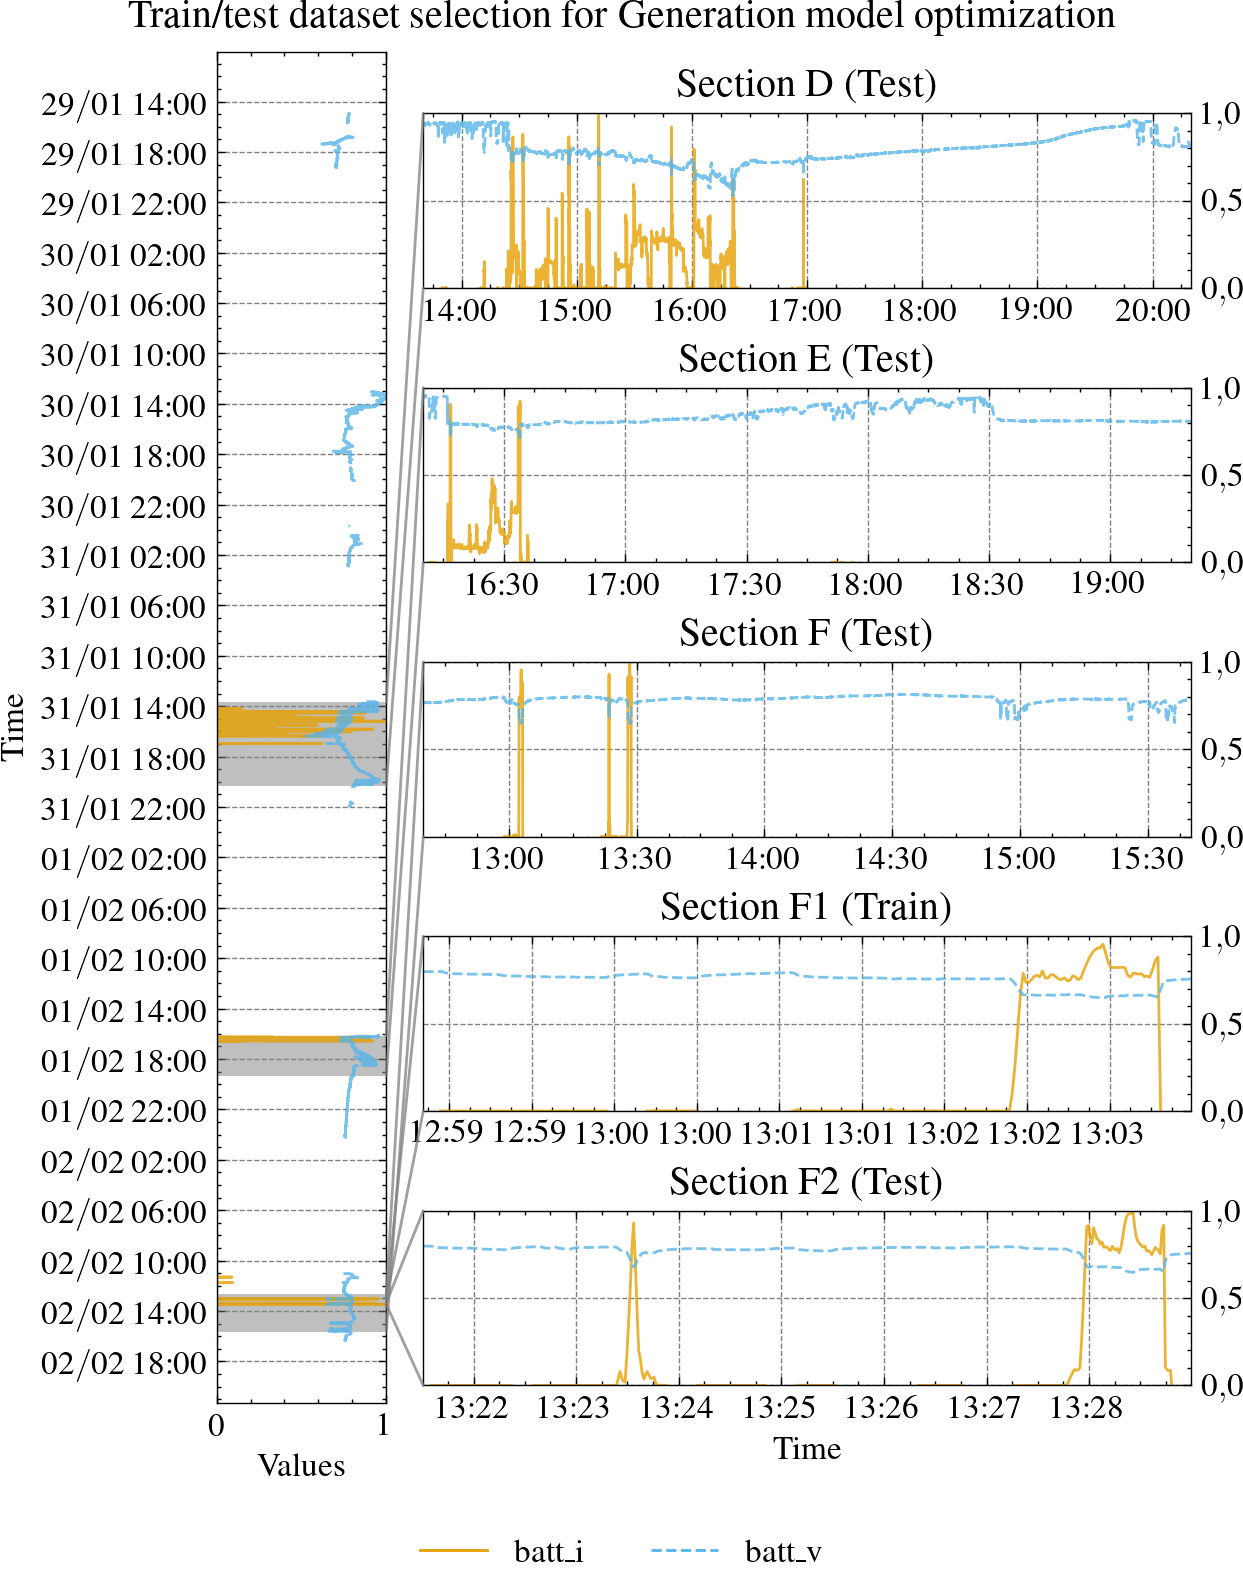

In [3]:
filename = "../../../models/2020/boat_data_1s.csv"
rename_columns = {
    'Battery Pack Voltage': 'batt_v',
    'Battery Current': 'batt_i',
    'ESC Duty Cycle': 'pilot_d',
    'Motor Angular Speed': 'motor_w',
    'PVs G': 'pv_g',
    # 'Solar POA': 'solar_poa',
    # 'Wind Speed': 'wind_v',
    # 'Air Temperature': 'air_t',
}
df = load_df(
    filename=filename,
    start=None,
    end=None,
    resample_rule=None,
    rename_columns=rename_columns,
    print_columns=False,
    iqr_threshold=None,
    cutoff_freq=None,
    sampling_rate=1,
    order=1,
    nominal_Q=nominal_Q,
    initial_SOC=initial_SOC
)

sections, tzinfo = get_sections()

# Customizing ranges:
# sections.loc['Section D', 'start'] = pd.Timestamp('2020-01-31 14:20:00')
# sections.loc['Section D', 'end'] = pd.Timestamp('2020-01-31 16:20:00')
# sections.loc['Section E', 'end'] = pd.Timestamp('2020-02-01 16:20:00')
sections.loc['Section F1'] = [pd.Timestamp('2020-02-02 12:58:50'), pd.Timestamp('2020-02-02 13:03:30')]
sections.loc['Section F2'] = [pd.Timestamp('2020-02-02 13:21:30'), pd.Timestamp('2020-02-02 13:29:00')]
sections = sections.loc[['Section D', 'Section E', 'Section F', 'Section F1', 'Section F2']]

train_section_name = 'Section F1'
train_test_sections = sections.reset_index().to_dict(orient='records')
train_section = sections.loc[sections.index == train_section_name].reset_index().to_dict(orient='records')[0]
test_sections = sections.loc[sections.index != train_section_name].reset_index().to_dict(orient='records')

train_size = 0
test_size = 0
for i in range(len(train_test_sections)):
    if train_test_sections[i]['name'] == train_section_name:
        train_test_sections[i]['name'] = train_test_sections[i]['name'] + ' (Train)'
        train_size += df.loc[(df.index >= train_test_sections[i]['start']) & (df.index <= train_test_sections[i]['end'])].size
    else:
        train_test_sections[i]['name'] = train_test_sections[i]['name'] + ' (Test)'
        test_size += df.loc[(df.index >= train_test_sections[i]['start']) & (df.index <= train_test_sections[i]['end'])].size


total_size = train_size+test_size
print(f'Train size ≃ {100*train_size/total_size:.2f}%')
print(f'Test size ≃ {100*test_size/total_size:.2f}%')

# Check for nans in the data
for section in train_test_sections:
    print('section:', section['name'], '-> nans:', df.loc[(df.index >= section['start']) & (df.index <= section['end'])].isna().sum().sum())

fig_save_and_show(
        filename=None,#f'{latex_img_path}/battery_optimization_test_residuals_{col}.pdf',
        show_title=f'Train/test dataset selection for Generation model optimization',
        save_title=f'Dataset da embarcação durante o DSB de 2019',
        ncol=4,
        fig=plot_events_data(
            events=train_test_sections,
            df=df,
            column_names=['batt_i', 'batt_v'],
            normalize=True,
        )
    )

# Battery Equivalent Circuit Model


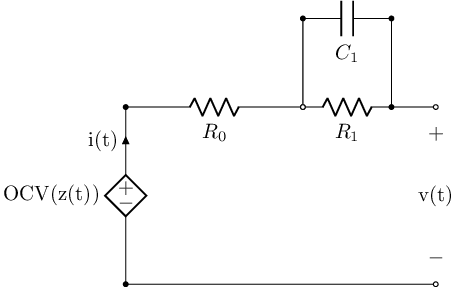

In [4]:
# !pip install lcapy zfitpy pyspice
# %pip install https://github.com/mph-/lcapy/archive/master.zip
# Open `tllocalmgr`, then `install circuitikz`, then `exit`, then `sudo texhash`
import lcapy as lca

circuit_draw_params = dict(
    # help_lines=1,
    # debug=True,
    draw_nodes=True,
    label_nodes=False,
    label_ids=True,
    label_values=False,
    cpt_size=1,
    node_spacing=3,
    scale=1,
    dpi=150,
)

circuit = lca.Circuit("""
E1 R0.1 0 2 0; down, l={OCV(z(t))}, i>={i(t)}
R0 .1 .2; right
R1 R0.2 .2; right=0.5
C1 .1 .2; right=0.5
W R1.1 C1.1; up=0.5
W R1.2 C1.2; up=0.5
W R1.2 P1.1; right=0.25
P1 .1 0_2; down, v={v(t)}
W 0 0_2; right
;""")
circuit.draw(**circuit_draw_params)
circuit.draw(**circuit_draw_params, filename="/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/battery_model.png")


![](feZkCLr.png)

De acordo com [Gregory L. Plett](https://books.google.com.br/books?id=suLRCgAAQBAJ&pg=PA29&hl=pt-BR&source=gbs_toc_r&cad=2#v=onepage&q&f=false), as seguintes equações representam o sistema da imagem acima, onde $z(t)$ é o estado de carga da bateria:

$$ \begin{aligned}
    \frac{di_{R_{1}}(t)}{dt} &= 
        -\frac{1}{R_{1} C_{1}} i_{R_{1}}(t) 
        +\frac{1}{R_{1} C_{1}} i(t) \\
    v(t) &= 
        -R_{1} i_{R_{1}}(t) 
        -R_{0} i(t) 
        +OCV(z(t)) 
\end{aligned} $$

O estado de carga ($z(t)$) pode ser definido como nas equações abaixo, onde $Q$ é a carga nominal da bateria, e $\eta$, a eficiência culombica:

$$ \begin{aligned}
    z(t) &= 
        z(t_{0}) 
        -\frac{1}{Q} \int_{t_{0}}^t \eta(t) i(t) dt \\
    \frac{dz(t)}{dt} &= 
        -\frac{\eta(t) i(t)}{Q}
\end{aligned} $$

Para que possam ser utilizadas os métodos de solução de sistemas no espaço de estados, podemos separar $VOC(z(t))$ em um modelo externo, considerando-o como uma entrada, deste modo, a função $VOC(z(t))$ pode ser um modelo caixa-preta.

In [5]:
import control as ct
from math import pi
from scipy.optimize import fsolve

def eval_poly(coeffs, x):
    result = 0.0
    for c in reversed(coeffs[1:]):
        result = (result + c) * x
    return result + coeffs[0]

class SolarBoat:
    @classmethod
    def initial_state(cls, X0: dict, U0, params: dict):
        X_guess = [10, 50, 1000, 0.5, 0]  # [batt_v_C1_0, motor_i_0, motor_w_0, esc_d_0, hull_u_0]

        # Params
        motor_B = params['motor_B']
        motor_K_Q = params['motor_K_Q']
        motor_R_A = params['motor_R_A']
        batt_R_1 = params['batt_R_1']

        # Input Initial Conditions
        batt_z_0 = X0['batt_z']  # Initial battery SOC

        # Inputs
        # pvs_g_0 = U0[0]  # Solar irradiation [W/m2]
        pilot_d_0 = U0[1]  # Pilot duty-cycle [unitless]

        # Initial condition equations
        def equations(X):
            batt_v_C1_0, motor_i_0, motor_w_0, esc_d_0, hull_u_0 = X

            # Outputs
            temp_x = np.array([batt_v_C1_0, batt_z_0, motor_i_0, motor_w_0, esc_d_0, hull_u_0])
            temp_u = U0
            y = cls._outputs(0, temp_x, temp_u, params)
            batt_i_0 = y[3]  # Initial Battery current [A]
            motor_v_0 = y[8]  # Initial Motor voltage [V]
            motor_q_load_0 = y[10]  # Initial Motor torque [Nm]

            motor_i_0_calc = (motor_B * motor_v_0 + motor_K_Q * motor_q_load_0) / (motor_B * motor_R_A + motor_K_Q**2)
            motor_w_0_calc = (motor_K_Q * motor_v_0 - motor_R_A * motor_q_load_0) / (motor_B * motor_R_A + motor_K_Q**2)
            batt_v_C1_0_calc = batt_R_1*batt_i_0
            esc_d_0_calc = pilot_d_0
            hull_u_0_calc = 0.0  # assume start from rest

            # Residuals
            return [
                batt_v_C1_0 - batt_v_C1_0_calc,
                motor_i_0 - motor_i_0_calc,
                motor_w_0 - motor_w_0_calc,
                esc_d_0 - esc_d_0_calc,
                hull_u_0 - hull_u_0_calc,
            ]

        solution = fsolve(equations, X_guess, xtol=1e-10)
        batt_v_C1_0, motor_i_0, motor_w_0, esc_d_0, hull_u_0 = solution

        return np.array([batt_v_C1_0, batt_z_0, motor_i_0, motor_w_0, esc_d_0, hull_u_0])

    @classmethod
    def _update(cls, t, x, u, params: dict):
        # Params
        batt_C_1 = params['batt_C_1']
        batt_eta = params['batt_eta']
        batt_Q = params['batt_Q']
        batt_R_1 = params['batt_R_1']
        esc_tau_fall = params['esc_tau_fall']
        esc_tau_rise = params['esc_tau_rise']
        hull_M = params['hull_M']
        hull_M = params['hull_M']
        hull_T_ded = params['hull_T_ded']
        motor_B = params['motor_B']
        motor_I_r = params['motor_I_r']
        motor_K_Q = params['motor_K_Q']
        motor_L_A = params['motor_L_A']
        motor_R_A = params['motor_R_A']
        prop_I_r = params['prop_I_r']
        trans_Iri = params['trans_Iri']
        trans_Iro = params['trans_Iro']
        trans_k = params['trans_k']
        motor_I_r_load = trans_Iri + trans_k**2 * (trans_Iro + prop_I_r)

        # Inputs
        # pv_g = u[0] # Solar irradiation [W/m2]
        pilot_d = u[1]  # Pilot duty-cycle [unitless]

        # States
        batt_v_C1 = x[0]  # Battery voltage through the internal serie-parallel resistance [V]
        # batt_z = x[1]  # Battery State Of Charge [unitless]
        motor_i = x[2]  # Motor current [A]
        motor_w = x[3]  # Motor angular speed [rad/s]
        esc_d = x[4]  # ESC duty-cycle [unitless]
        # hull_u = x[5]  # Hull speed [m/s]

        # Outputs
        y = cls._outputs(t, x, u, params)
        batt_i = y[3]
        esc_d = y[6]
        motor_v = y[8]
        motor_w = y[9]
        motor_q_load = y[10]
        prop_t = y[16]
        hull_r = y[18]

        # System of differential equations
        d_batt_v_C1 = (batt_R_1*batt_i - batt_v_C1)/(batt_C_1*batt_R_1)
        d_batt_z = -batt_eta*batt_i/batt_Q
        d_motor_i = (-motor_R_A * motor_i - motor_K_Q * motor_w + motor_v) / motor_L_A
        d_motor_w = (-motor_B * motor_w + motor_i * motor_K_Q - motor_q_load) / (motor_I_r + motor_I_r_load)
        prop_t_eff = (1.0 - hull_T_ded) * prop_t
        d_hull_u = (prop_t_eff - hull_r) / hull_M
        if pilot_d > esc_d:
            d_esc_d = (pilot_d - esc_d) / esc_tau_rise
        else:
            d_esc_d = (pilot_d - esc_d) / esc_tau_fall

        return np.array([d_batt_v_C1, d_batt_z, d_motor_i, d_motor_w, d_esc_d, d_hull_u])

    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Params
        batt_N_S = params['batt_N_S']
        batt_k_V_OC_coeffs = params['batt_k_V_OC_coeffs']
        batt_R_0 = params['batt_R_0']
        batt_N_S = params['batt_N_S']
        esc_eta = params['esc_eta']
        hull_C_T = params['hull_C_T']
        hull_S_air = params['hull_S_air']
        hull_S_water = params['hull_S_water']
        hull_W = params['hull_W']
        mppt_eta = params['mppt_eta']
        mppts_n = params['mppts_n']
        others_pi = params['others_pi']
        prop_D = params['prop_D']
        prop_k_Q_coeffs = params['prop_k_Q_coeffs']
        prop_k_T_coeffs = params['prop_k_T_coeffs']
        pv_S = params['pv_S']
        pv_eta = params['pv_eta']
        rho_air = params['rho_air']
        rho_water = params['rho_water']
        trans_eta = params['trans_eta']
        trans_k = params['trans_k']

        # Inputs
        pv_g = u[0]  # Total incident irradiance [W/m^2]
        # pilot_d = u[1]  # Pilot duty-cycle

        # States
        batt_v_C1 = x[0]  # battery current through the internal serie-parallel resistance [V]
        batt_z = x[1]  # battery State Of Charge [unitless]
        motor_i = x[2]  # Motor current [A]
        motor_w = x[3]  # Motor angular speed [rad/s]
        esc_d = x[4]  # ESC duty-cycle [unitless]
        hull_u = x[5]  # Hull speed [m/s]

        # Output equations
        prop_w = motor_w*trans_k
        prop_n = prop_w / (2*pi)  # Angular speed in revolutions [RPS]

        u_rel = (1.0 - hull_W) * hull_u
        prop_J = np.clip(u_rel/(prop_D*(prop_w + 1e-6)), a_min=0, a_max=1.5)  # avoid div by zero
        prop_k_q = max(0, eval_poly(prop_k_Q_coeffs, prop_J))  # Assuming forward operation
        prop_k_T = max(0, eval_poly(prop_k_T_coeffs, prop_J))  # Assuming forward operation

        prop_q = prop_D**5*prop_k_q*abs(prop_n)*prop_n*rho_water
        prop_t = prop_D**4*prop_k_T*abs(prop_n)*prop_n*rho_water
        motor_q_load = prop_q*trans_k/trans_eta
        hull_r = hull_C_T*hull_u**2*(hull_S_air*rho_air + hull_S_water*rho_water)/2

        esc_i_in = max(0, esc_d*motor_i/esc_eta)  # Our ESC is a half-bridge, no regeneration allowed
        batt_ocv = eval_poly(batt_k_V_OC_coeffs, batt_z)
        batt_v = -batt_R_0*batt_N_S*esc_i_in/2 + np.sqrt(batt_N_S)*np.sqrt(4*batt_R_0*mppt_eta*mppts_n*pv_S*pv_eta*pv_g - 4*batt_R_0*others_pi + batt_N_S*(batt_R_0*esc_i_in - batt_ocv + batt_v_C1)**2)/2 + batt_N_S*batt_ocv/2 - batt_N_S*batt_v_C1/2
        motor_v = batt_v*esc_d
        mppts_i_out = mppt_eta*mppts_n*pv_S*pv_eta*pv_g/batt_v
        others_ii = others_pi/batt_v
        batt_i = esc_i_in - mppts_i_out + others_ii

        return np.array([
            batt_v,
            batt_z,
            batt_N_S*batt_ocv,
            batt_i,
            mppts_i_out,
            others_ii,
            esc_d,
            esc_i_in,
            motor_v,
            motor_w,
            motor_q_load,
            prop_k_q,
            prop_k_T,
            prop_J,
            prop_q,
            prop_w,
            prop_t,
            hull_u,
            hull_r
        ])


    @classmethod
    def build(cls, params: dict):
        return ct.NonlinearIOSystem(
            cls._update,
            cls._outputs,
            name='solar_boat',
            states=('batt_v_C1', 'batt_z', 'motor_i', 'motor_w', 'esc_d', 'hull_u'),
            inputs=('pv_g', 'pilot_d'),
            outputs=('batt_v', 'batt_z', 'batt_ocv', 'batt_i', 'mppts_i_out', 'others_ii', 'esc_d', 'esc_i_in', 'motor_v', 'motor_w', 'motor_q_load', 'prop_k_q', 'prop_k_T', 'prop_J', 'prop_q', 'prop_w', 'prop_t', 'hull_u', 'hull_r'),
            params=params,
        )

SolarBoat.build({})

<NonlinearIOSystem:solar_boat:['pv_g', 'pilot_d']->['batt_v', 'batt_z', 'batt_ocv', 'batt_i', 'mppts_i_out', 'others_ii', 'esc_d', 'esc_i_in', 'motor_v', 'motor_w', 'motor_q_load', 'prop_k_q', 'prop_k_T', 'prop_J', 'prop_q', 'prop_w', 'prop_t', 'hull_u', 'hull_r']>

array([  10.50077129,   11.70306904,  -47.97673888,  120.12010661,
       -163.22052539,  113.26357466,  -31.29084967])

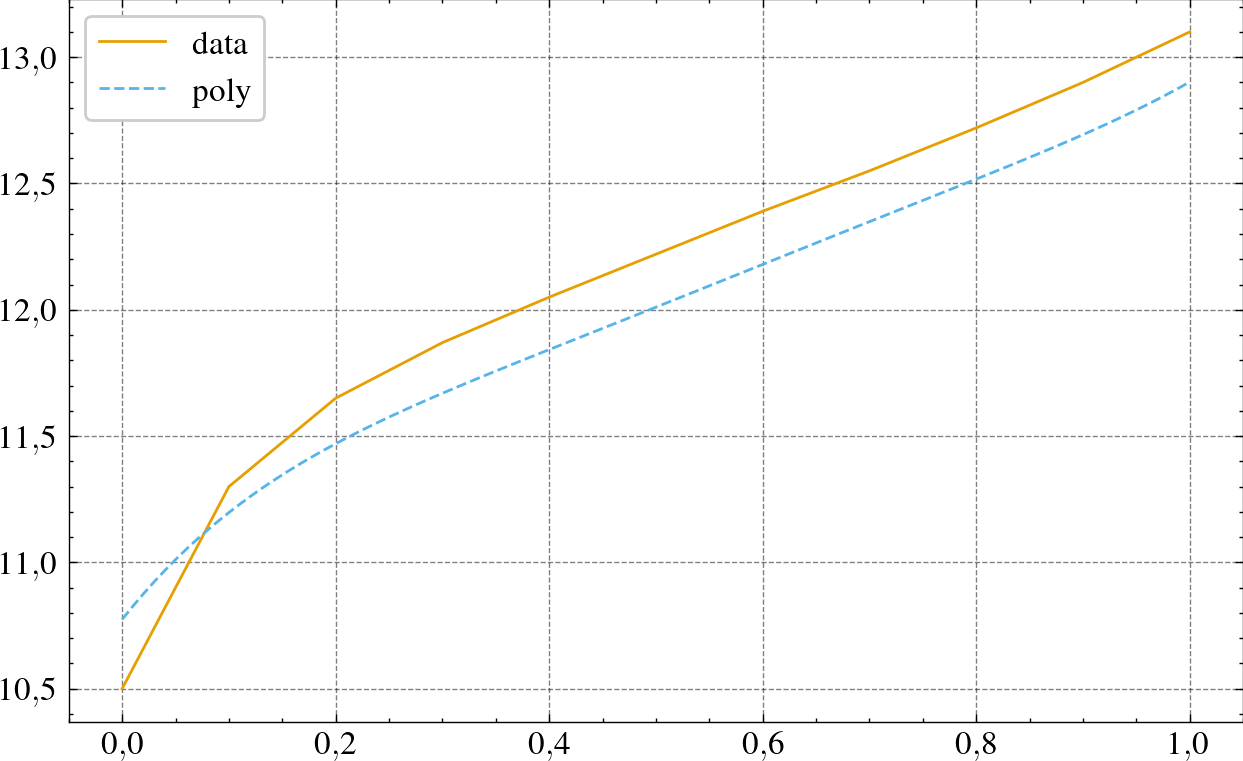

In [6]:
plt.figure()

# From: https://imgv2-2-f.scribdassets.com/img/document/682244176/original/0a169c4659/1730632177?v=1
ocv = np.array([13.1, 12.9, 12.72, 12.55, 12.39, 12.22, 12.05, 11.87, 11.65, 11.3, 10.5])[::-1]
soc = np.array([1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0])[::-1]
plt.plot(soc, ocv, label='data')

soc_test = np.linspace(0, 1, 100)

deg = 6
batt_k_V_OC_coeffs = np.polynomial.Polynomial.fit(soc, ocv, deg, domain=[0, 1], window=[0, 1]).coef
display(batt_k_V_OC_coeffs)

batt_k_V_OC_coeffs = np.array([10.77420498818087, 5.342402189767365, -13.256712152302418, 23.44686407251436, -20.24985001372384, 6.845076498059946])

ocv_poly = eval_poly(batt_k_V_OC_coeffs, soc_test)
# or: ocv_poly = np.polynomial.Polynomial(batt_k_V_OC_coeffs)(soc_test)
plt.plot(soc_test, ocv_poly, label='poly')
plt.legend()
plt.show()

In [7]:
propulsion_params = {
    # From models/2020/Motor/me0909_free_rotor_step.ipynb:
    'motor_B': 0.01552291297807313,
    'motor_K_Q': 0.10352558686425843,
    'motor_R_A': 0.018933649226687745,
    'motor_L_A': 6.666812008210278e-05,
    'motor_I_r': 0.011056915252158687,
    'rho_water': 1023,
    'rho_air': 1.1839,
    'esc_eta': 0.866,
    'esc_tau_fall': 1.2750449985439274,
    'esc_tau_rise': 0.25534685827849624,
    'trans_eta': 0.9,
    'trans_Iri': 0,
    'trans_Iro': 0,
    'trans_k': 0.6363636363636364,
    'prop_D': 0.2286,
    'prop_k_T_coeffs': [0.09999871540716215, 0.06596122303461704],
    'prop_k_Q_coeffs': [0.011187180876140401, 0.06590461151481068],
    'prop_I_r': 0.0709943727701415,
    'hull_C_T': 0.005475489082603877,
    'hull_M': 293.7,
    'hull_S_water': 4.142904990019334,
    'hull_S_air': 4.094995009980666,
    'hull_T_ded': 0.0855,
    'hull_W': 0.1425,
}

generation_params = {
    'pv_S': 1.650 * 0.992,
    'pv_eta': 0.15553439343946882,
    'mppt_eta': 0.9169846082963471,
    'mppts_n': 4,
}

battery_params = {
    'batt_eta': 1,
    'batt_Q': cell_amps_hour * 3600,
    'batt_R_0': 0.05,
    'batt_R_1': 0.01,
    'batt_C_1': 10000,
    'batt_N_S': 3,
    'batt_k_V_OC_coeffs': batt_k_V_OC_coeffs,
}

others_params = {
    'others_pi': 1.5 * 18,
}

solar_boat_params = generation_params | battery_params | propulsion_params | others_params
solar_boat_params

{'pv_S': 1.6367999999999998,
 'pv_eta': 0.15553439343946882,
 'mppt_eta': 0.9169846082963471,
 'mppts_n': 4,
 'batt_eta': 1,
 'batt_Q': 172800,
 'batt_R_0': 0.05,
 'batt_R_1': 0.01,
 'batt_C_1': 10000,
 'batt_N_S': 3,
 'batt_k_V_OC_coeffs': array([ 10.77420499,   5.34240219, -13.25671215,  23.44686407,
        -20.24985001,   6.8450765 ]),
 'motor_B': 0.01552291297807313,
 'motor_K_Q': 0.10352558686425843,
 'motor_R_A': 0.018933649226687745,
 'motor_L_A': 6.666812008210278e-05,
 'motor_I_r': 0.011056915252158687,
 'rho_water': 1023,
 'rho_air': 1.1839,
 'esc_eta': 0.866,
 'esc_tau_fall': 1.2750449985439274,
 'esc_tau_rise': 0.25534685827849624,
 'trans_eta': 0.9,
 'trans_Iri': 0,
 'trans_Iro': 0,
 'trans_k': 0.6363636363636364,
 'prop_D': 0.2286,
 'prop_k_T_coeffs': [0.09999871540716215, 0.06596122303461704],
 'prop_k_Q_coeffs': [0.011187180876140401, 0.06590461151481068],
 'prop_I_r': 0.0709943727701415,
 'hull_C_T': 0.005475489082603877,
 'hull_M': 293.7,
 'hull_S_water': 4.142904990

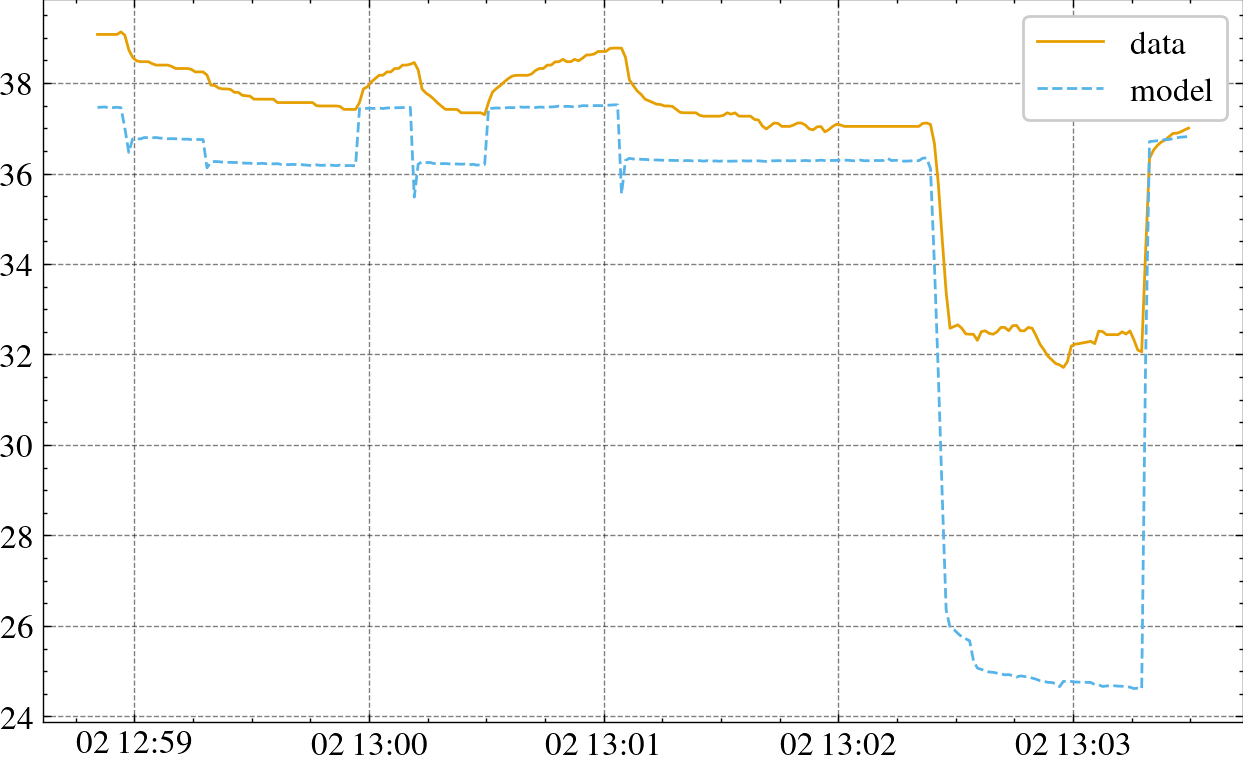

In [8]:
# Select the optimization data
# data_cols = ['batt_v', 'batt_i', 'motor_w']
data_cols = ['batt_v']
input_cols = ['pv_g', 'pilot_d']

df_train = df.loc[(df.index >= train_section['start']) & (df.index <= train_section['end']), ['t'] + data_cols + input_cols][:1000]

# Time array
T = np.ascontiguousarray(df_train['t'].to_numpy())

# Inputs
U = np.ascontiguousarray(df_train[input_cols].to_numpy().T)

# Model
solar_boat = SolarBoat.build(solar_boat_params)

# Initial state
X0 = SolarBoat.initial_state(
    X0=dict(batt_z=0.65),
    U0=U[:,0],
    params=solar_boat_params,
)

# Simulation
res = ct.input_output_response(solar_boat, T=T, U=U, X0=X0, solve_ivp_method='Radau')
ydata = res.to_pandas().set_index('time')[res.output_labels]

plt.plot(df_train.index, df_train['batt_v'], label='data')
plt.plot(df_train.index, ydata['batt_v'], label='model')
plt.legend(loc='upper right')
plt.show()

# Sensitivity Analysis

In [9]:
def model_function(T, U, X0, **params):
    return ct.input_output_response(
        SolarBoat.build(params=params),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method='Radau',
    ).to_pandas()

def solat_boat_sensitivity_analysis_step_response(
    params_description: dict,
    solar_poa_step: float,
    pilot_d_step: float,
    samples: int,
    do_plot=True,
    calc_second_order=True,
):

    model_class = SolarBoat
    model_params = solar_boat_params.copy()
    model_tmp = model_class.build(model_params)

    # Time array
    T = np.linspace(0, 10, 11, endpoint=True)

    # Input data
    U = np.empty([model_tmp.ninputs, len(T)]) * np.nan # nan to force us to define every input
    U[model_tmp.input_labels.index('solar_poa')] = solar_poa_step
    U[model_tmp.input_labels.index('pilot_d')] = pilot_d_step

    # Initial state
    X0 = model_class.initial_state(
        X0=dict(),
        U0=U[:,0],
        params=model_params,
    )

    df_sa, problem = sobol_sensitivity_analysis_from_model_params_to_outputs(
        params_description=params_description,
        T=T,
        U=U,
        X0=X0,
        model_function=model_function,
        model_class=model_class,
        model_params=model_params,
        samples=samples,
        calc_second_order=calc_second_order,
        seed=42,
        nprocs=32,
    )

    df_steady_state_mean = get_region_mean(df_sa, t_start=8, t_end=10)

    export_dataframe_to_latex(
        filename=f"{latex_tex_path}/solar_boat_sensitivity_analysis.tex",
        label=f'table:solar_boat_sensitivity_analysis',
        caption='Índices de Sobol em regime permanente',
        df_steady_state_mean=df_steady_state_mean,
    )

    if do_plot:
        display(df_steady_state_mean)

        # fig_save_and_show(
        #     None,
        #     'Distribuição dos valores para cada fator',
        #     'Distribution of the values for each factor',
        #     fig=plot_sampled_distribuitions(problem),
        #     ncols=3,
        # )

        # for output in df_sa['output'].unique():
        #     fig_save_and_show(
        #         None,
        #         f'Índices de Sobol para a saída {output} durante o tempo',
        #         f'Sobol Indices for the output {output} over time\nwith step of {duty_cycle_step*100} [\%] and {voltage_step} [V],\nwith {samples} samples',
        #         fig=plot_sensitivity_analysis(df_sa, output=output),
        #         ncols=3,
        #     )

        # for output in df_sa['output'].unique():
        #     fig_save_and_show(
        #         None,
        #         f'Índices de Sobol para a saída {output} durante o tempo',
        #         f'Sobol Indices for the output {output} over time\nwith step of {duty_cycle_step*100} [\%] and {voltage_step} [V],\nwith {samples} samples',
        #         fig=plot_sensitivity_analysis_heatmaps(df_sa, output=output),
        #         ncols=3,
        #     )

        for output in df_sa['output'].unique():
            fig_save_and_show(
                f'{latex_img_path}/solar_boat_sensitivity_analysis_{output}.pdf',
                f'Índices de Sobol para a saída {output} em regime permanente',
                f'Sobol Indices for the output {output} at steady-state\nwith step of {duty_cycle_step*100} [%] and {voltage_step} [V],\nwith {samples} samples',
                fig=plot_sensitivity_analysis_bars(df_steady_state_mean, output=output),
                ncols=3,
            )

    return df_sa, problem


In [10]:
# # Setting all uncertainties to be x%
# u_motor_R_A = 1/100
# u_motor_L_A = 1/100
# u_motor_B = 1/100
# u_motor_I_r = 1/100
# u_motor_K_Q = 1/100
# u_prop_I = 1/100
# u_prop_K_Q = 1/100
# u_prop_D = 1/100
# u_rho_water = 1/100
# u_trans_eff = 1/100
# u_esc_eff = 1/100
# u_esc_tau_rise = 1/100
# u_esc_tau_fall = 1/100
# u_trans_K = 1/100
# u_v_mppt = 0.5 / 100
# u_i_mppt = 1 / 100
# u_p_mppt = ((u_v_mppt)**2 + (u_i_mppt)**2)**0.5
# u_eta_mppt = ((u_p_mppt)**2 + (u_p_mppt)**2)**0.5
# u_pv_area = 0.63/100
# u_pv_eff = 3.9/100

# params_description = {
#     'pv_S': describe_param_with_uniform_distribution(lower=generation_params['pv_S']*(1-u_pv_area), upper=generation_params['pv_S']*(1+u_pv_area)),
#     'pv_eta': describe_param_with_uniform_distribution(lower=generation_params['pv_eta']*(1-u_pv_eff), upper=generation_params['pv_eta']*(1+u_pv_eff)),
#     'mppt_eta': describe_param_with_uniform_distribution(lower=generation_params['mppt_eta']*(1-u_eta_mppt), upper=generation_params['mppt_eta']*(1+u_eta_mppt)),
#     'motor_R_A': describe_param_with_uniform_distribution(lower=solar_boat_params['motor_R_A']*(1-u_motor_R_A), upper=solar_boat_params['motor_R_A']*(1+u_motor_R_A)),
#     'motor_L_A': describe_param_with_uniform_distribution(lower=solar_boat_params['motor_L_A']*(1-u_motor_L_A), upper=solar_boat_params['motor_L_A']*(1+u_motor_L_A)),
#     'motor_B': describe_param_with_uniform_distribution(lower=solar_boat_params['motor_B']*(1-u_motor_B), upper=solar_boat_params['motor_B']*(1+u_motor_B)),
#     'motor_I_r': describe_param_with_uniform_distribution(lower=solar_boat_params['motor_I_r']*(1-u_motor_I_r), upper=solar_boat_params['motor_I_r']*(1+u_motor_I_r)),
#     'motor_K_Q': describe_param_with_uniform_distribution(lower=solar_boat_params['motor_K_Q']*(1-u_motor_K_Q), upper=solar_boat_params['motor_K_Q']*(1+u_motor_K_Q)),
#     'prop_I_r': describe_param_with_uniform_distribution(lower=solar_boat_params['prop_I_r']*(1-u_prop_I), upper=solar_boat_params['prop_I_r']*(1+u_prop_I)),
#     'prop_K_Q': describe_param_with_uniform_distribution(lower=solar_boat_params['prop_K_Q']*(1-u_prop_K_Q), upper=solar_boat_params['prop_K_Q']*(1+u_prop_K_Q)),
#     'prop_D': describe_param_with_uniform_distribution(lower=solar_boat_params['prop_D']*(1-u_prop_D), upper=solar_boat_params['prop_D']*(1+u_prop_D)),
#     'rho_water': describe_param_with_uniform_distribution(lower=solar_boat_params['rho_water']*(1-u_rho_water), upper=solar_boat_params['rho_water']*(1+u_rho_water)),
#     'trans_eta': describe_param_with_uniform_distribution(lower=solar_boat_params['trans_eta']*(1-u_trans_eff), upper=solar_boat_params['trans_eta']*(1+u_trans_eff)),
#     'esc_eta': describe_param_with_uniform_distribution(lower=solar_boat_params['esc_eta']*(1-u_esc_eff), upper=solar_boat_params['esc_eta']*(1+u_esc_eff)),
#     'esc_tau_rise': describe_param_with_uniform_distribution(lower=solar_boat_params['esc_tau_rise']*(1-u_esc_tau_rise), upper=solar_boat_params['esc_tau_rise']*(1+u_esc_tau_rise)),
#     'esc_tau_fall': describe_param_with_uniform_distribution(lower=solar_boat_params['esc_tau_fall']*(1-u_esc_tau_fall), upper=solar_boat_params['esc_tau_fall']*(1+u_esc_tau_fall)),
#     'trans_k': describe_param_with_uniform_distribution(lower=solar_boat_params['trans_k']*(1-u_trans_K), upper=solar_boat_params['trans_k']*(1+u_trans_K)),
# }

# df_sa, problem = solar_boat_sensitivity_analysis_step_response(
#     params_description=params_description,
#     voltage_step=36,
#     duty_cycle_step=1,
#     samples=2**14,
#     do_plot=True,
#     calc_second_order=False,
# )

# Optimization

In [11]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.nelder import NelderMead
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.isres import ISRES
from pymoo.algorithms.soo.nonconvex.es import ES
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
from pymoo.algorithms.soo.nonconvex.pattern import PatternSearch
from pymoo.operators.sampling.lhs import LHS
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.parallelization.starmap import StarmapParallelization
from multiprocessing.pool import ThreadPool
from multiprocessing import Pool

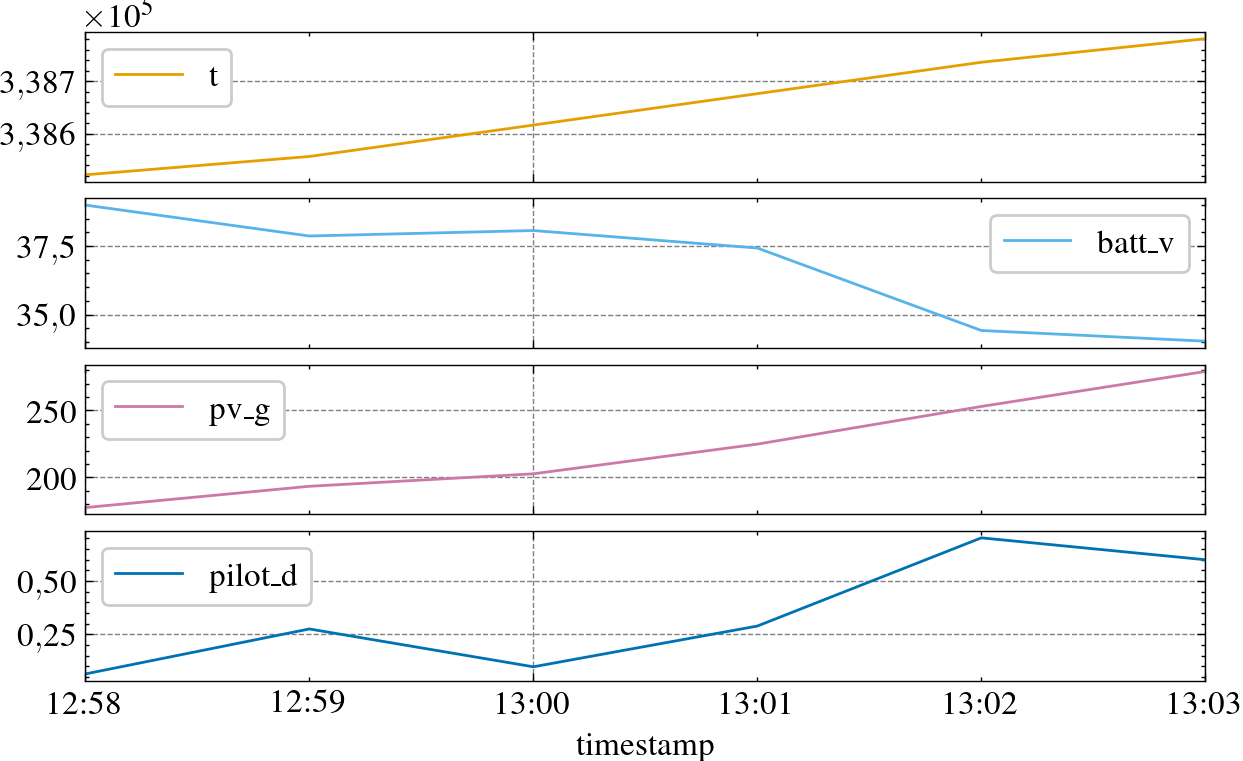

,t,batt_v,pv_g,pilot_d
count,6.000000,6.000000,6.000000,6.000000
mean,338648.166667,36.799959,221.749401,0.338324
std,101.816829,2.062397,38.396085,0.260841
min,338521.500000,34.030394,177.581007,0.064548
25%,338571.500000,35.171903,195.758250,0.142463
50%,338646.500000,37.645747,213.787669,0.282343
75%,338721.500000,38.014949,245.904792,0.522290
max,338781.500000,38.992562,278.981119,0.702602


In [12]:
df_train = df.loc[
        (df.index >= train_section['start']) & (df.index <= train_section['end']),
        ['t'] + data_cols + input_cols + ['batt_i']
    ].resample('1min').mean().interpolate(method='time')

df_train.plot(subplots=True)
plt.show()

df_train.describe()

In [13]:
%%time
## BATTERY OPTIMIZATION

import numpy as np
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.termination import get_termination

def run_battery_optimization(
    df,
    train_section,
    nominal_Q,
    battery_params,
    model_function,
    initial_SOC
):
    """
    Run the battery optimization with a hyperparameterized initial_SOC.
    (Implementation as provided in your code snippet)
    """
    # Define optimization and input data columns
    # data_cols = ['batt_v', 'batt_i', 'motor_w']
    data_cols = ['batt_v']
    input_cols = ['pv_g', 'pilot_d']

    # Extract and resample training data
    df_train = df.loc[
        (df.index >= train_section['start']) & (df.index <= train_section['end']),
        ['t'] + data_cols + input_cols + ['batt_i']
    ].resample('1min').mean().interpolate(method='time')

    # Compute battery capacity and SOC using the hyperparameter initial_SOC
    compute_df_capacity(df_train, nominal_Q, initial_SOC, inplace=True)
    compute_df_soc(df_train, nominal_Q, inplace=True)
    # Optionally adjust batt_z (if needed)
    # df_train['batt_z'] = df_train['batt_z'] - df_train['batt_z'].min()

    # Set model state initial conditions
    input_initial_state = {
        'batt_z': df_train['batt_z'].iloc[0]
    }

    # Initialize parameter bounds for the optimization
    params_bounds = {
        'batt_R_0': dict(min=1e-3, max=1),
        'batt_R_1': dict(min=1e-3, max=1),
        'batt_C_1': dict(min=1, max=1e6),
    }
    poly_coeffs = [
        # {'name': 'batt_k_V_OC_coeffs', 'n_coeffs': 2, 'x_interval': (0, 1), 'y_bounds': (0.5*10.5, 2*13.5)},
        # {'name': 'batt_R_0_coeffs', 'n_coeffs': 1, 'x_interval': (0, 1), 'y_bounds': (1e-3, 1)},
        # {'name': 'batt_R_1_coeffs', 'n_coeffs': 1, 'x_interval': (0, 1), 'y_bounds': (1e-3, 1)},
        # {'name': 'batt_C_1_coeffs', 'n_coeffs': 1, 'x_interval': (0, 1), 'y_bounds': (1, 1e6)},
    ]
    for coeff in poly_coeffs:
        name = coeff['name']
        n_coeffs = coeff['n_coeffs']
        y_bounds = coeff['y_bounds']
        coeff_bounds = estimate_polynomial_coefficient_bounds(
            x_interval=(0, 1), y_bounds=y_bounds, degree=(n_coeffs - 1)
        )
        for i in range(n_coeffs):
            params_bounds[f'{name}_{i}'] = dict(min=coeff_bounds[i][0], max=coeff_bounds[i][1])

    # Initialize the multiprocessing pool and parallel runner
    from multiprocessing import Pool
    n_processes = 32
    pool = Pool(processes=n_processes)
    runner = StarmapParallelization(pool.starmap)

    # Define the battery model and parameters
    model = SolarBoat
    model_params = solar_boat_params.copy()

    # Set up the optimization problem
    problem = MyOptimizationProblem(
        model=model,
        model_function=model_function,
        training_data=df_train,
        training_data_columns=data_cols,
        model_params=model_params,
        opt_params_bounds=params_bounds,
        input_initial_state=input_initial_state,
        input_columns=input_cols,
        data_scaler=MinMaxScaler,
        elementwise_runner=runner,
    )

    # Configure the optimization algorithm (Differential Evolution)
    algorithm = DE(
        pop_size=10 * len(params_bounds),
        sampling=LHS(),
        variant="DE/rand/1/bin",
        F=0.2,
        CR=0.9,
    )

    # Set termination criteria
    termination = DefaultSingleObjectiveTermination(
        xtol=1e-8,
        cvtol=1e-6,
        ftol=1e-6,
        period=20,
        n_max_gen=1000,
        n_max_evals=100000,
    )

    # Run the battery optimization
    result = minimize(
        problem,
        algorithm,
        termination=termination,
        seed=42,
        verbose=True,
        save_history=True,
    )

    pool.close()
    pool.join()

    return result

# Define the hyperparameter optimization problem for initial_SOC

class BatteryHyperParameterProblem(Problem):
    def __init__(self, df, train_section, nominal_Q, battery_params, model_function):
        # One decision variable (initial_SOC) in [0, 1] and one objective.
        super().__init__(n_var=1, n_obj=1, xl=np.array([0.0]), xu=np.array([1.0]))
        self.df = df
        self.train_section = train_section
        self.nominal_Q = nominal_Q
        self.battery_params = battery_params
        self.model_function = model_function

    def _evaluate(self, X, out, *args, **kwargs):
        # X is an array of shape (n_samples, 1), each row is an initial_SOC candidate.
        f_vals = []
        for x in X:
            initial_SOC = x[0]
            print(f"Evaluating for initial_SOC = {initial_SOC:.4f}")
            result = run_battery_optimization(
                self.df,
                self.train_section,
                self.nominal_Q,
                self.battery_params,
                self.model_function,
                initial_SOC=initial_SOC
            )
            # Here we assume the battery optimization result has an attribute F that gives the objective value.
            f_vals.append(result.F)
        out["F"] = np.array(f_vals).reshape(-1, 1)

# Set up and run the hyperparameter optimization

# Instantiate the hyperparameter optimization problem.
hyper_problem = BatteryHyperParameterProblem(
    df=df,
    train_section=train_section,
    nominal_Q=nominal_Q,
    battery_params=battery_params,
    model_function=model_function,
)

# Configure the algorithm for the hyperparameter search.
algorithm_hyper = DE(
    pop_size=10,
    variant="DE/rand/1/bin",
    F=0.5,
    CR=0.9,
)
# algorithm_hyper = NelderMead()

# Define a termination criterion
termination_hyper = DefaultSingleObjectiveTermination(
    xtol=1e-8,
    cvtol=1e-6,
    ftol=1e-6,
    period=10,
    n_max_gen=1000,
    n_max_evals=100000,
)

# Run the hyperparameter optimization.
result_hyper = minimize(
    hyper_problem,
    algorithm_hyper,
    termination=termination_hyper,
    seed=42,
    verbose=True,
)

print("Best initial_SOC found:", result_hyper.X)
print("Objective value at best initial_SOC:", result_hyper.F)

initial_SOC = result_hyper.X

Evaluating for initial_SOC = 0.7740
n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       30 |  2.8077078918 |  0.0194696199
     2 |       60 |  2.0078680870 |  0.0194696199
     3 |       90 |  1.4512508196 |  0.0194696199
     4 |      120 |  0.8830764752 |  0.0194696199
     5 |      150 |  0.6134671087 |  0.0194696199
     6 |      180 |  0.3936817615 |  0.0164691011
     7 |      210 |  0.2349112484 |  0.0164691011
     8 |      240 |  0.1086863873 |  0.0120490556
     9 |      270 |  0.0707580732 |  0.0120490556
    10 |      300 |  0.0383724544 |  0.0113935423
    11 |      330 |  0.0243570727 |  0.0113935423
    12 |      360 |  0.0201729471 |  0.0102853479
    13 |      390 |  0.0167027445 |  0.0102853479
    14 |      420 |  0.0154381237 |  0.0102853479
    15 |      450 |  0.0142218924 |  0.0078494555
    16 |      480 |  0.0130397631 |  0.0077800020
    17 |      510 |  0.0128700178 |  0.0077800020
    18 |      540 |  0.0122384870 |  0.0077800020
    19 |      

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       60 |  1.4646383294 |  0.0487825486
     2 |      120 |  1.1216065832 |  0.0348690620
     3 |      180 |  0.8688869433 |  0.0188028951
     4 |      240 |  0.5819427100 |  0.0172538617
     5 |      300 |  0.3602592863 |  0.0067366192
     6 |      360 |  0.1886741121 |  0.0067366192
     7 |      420 |  0.0921368287 |  0.0051900642
     8 |      480 |  0.0626050750 |  0.0051900642
     9 |      540 |  0.0412683026 |  0.0051900642
    10 |      600 |  0.0230562341 |  0.0051900642
    11 |      660 |  0.0166701979 |  0.0050770564
    12 |      720 |  0.0124404604 |  0.0046537073
    13 |      780 |  0.0096550821 |  0.0040684311
    14 |      840 |  0.0080415826 |  0.0040684311
    15 |      900 |  0.0071207105 |  0.0040121743
    16 |      960 |  0.0062611783 |  0.0040121743
    17 |     1020 |  0.0056635438 |  0.0040121743
    18 |     1080 |  0.0051492215 |  0.0040121743
    19 |     1140 |  0.0049583400 |  0.0037813484


{'batt_R_0': 0.05, 'batt_R_1': 0.01, 'batt_C_1': 10000}

Best parameters found:


{'batt_R_0': 0.01345030557242485,
 'batt_R_1': 0.24515494184977685,
 'batt_C_1': 16768.74961165642}

Objective value at solution: [0.00351264]


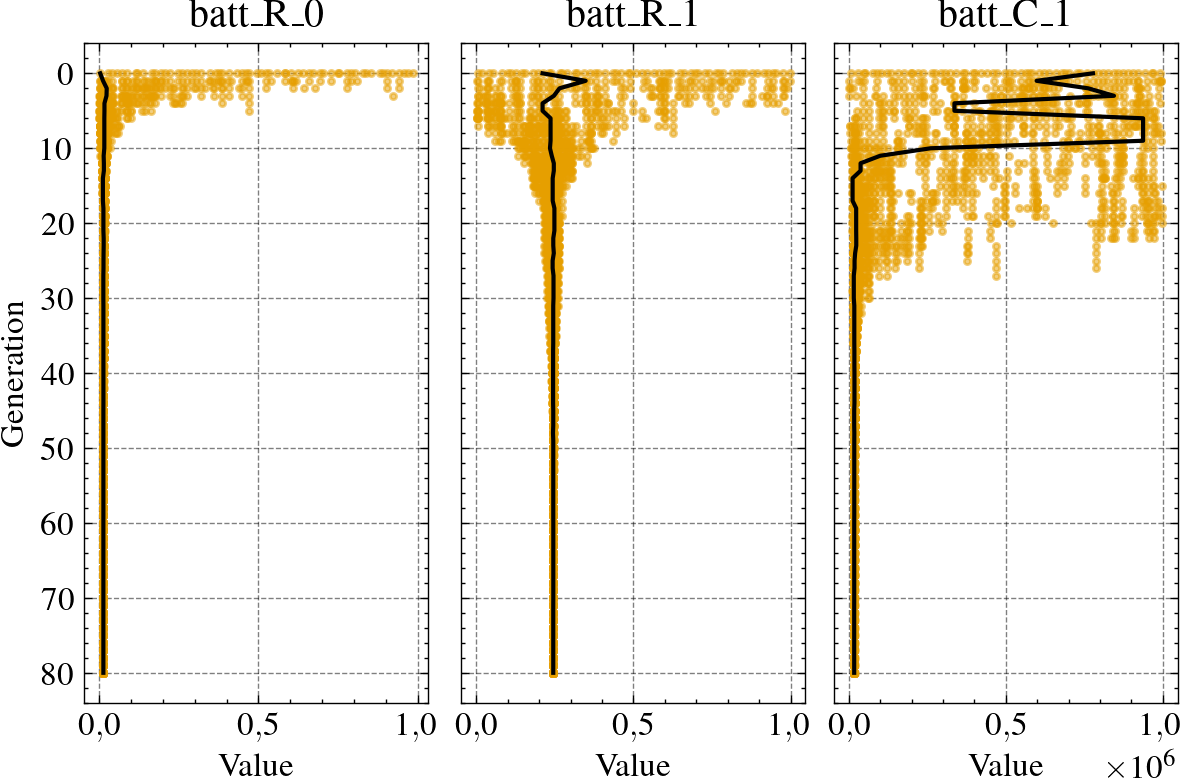

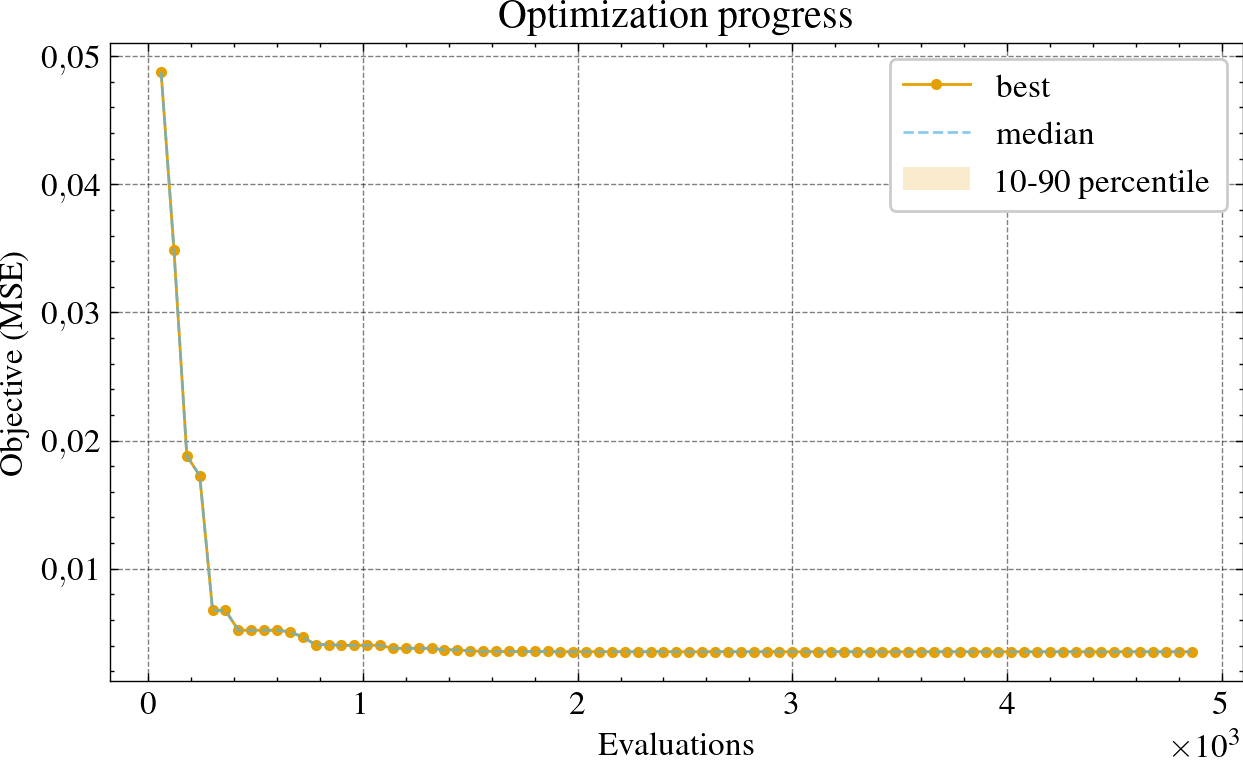

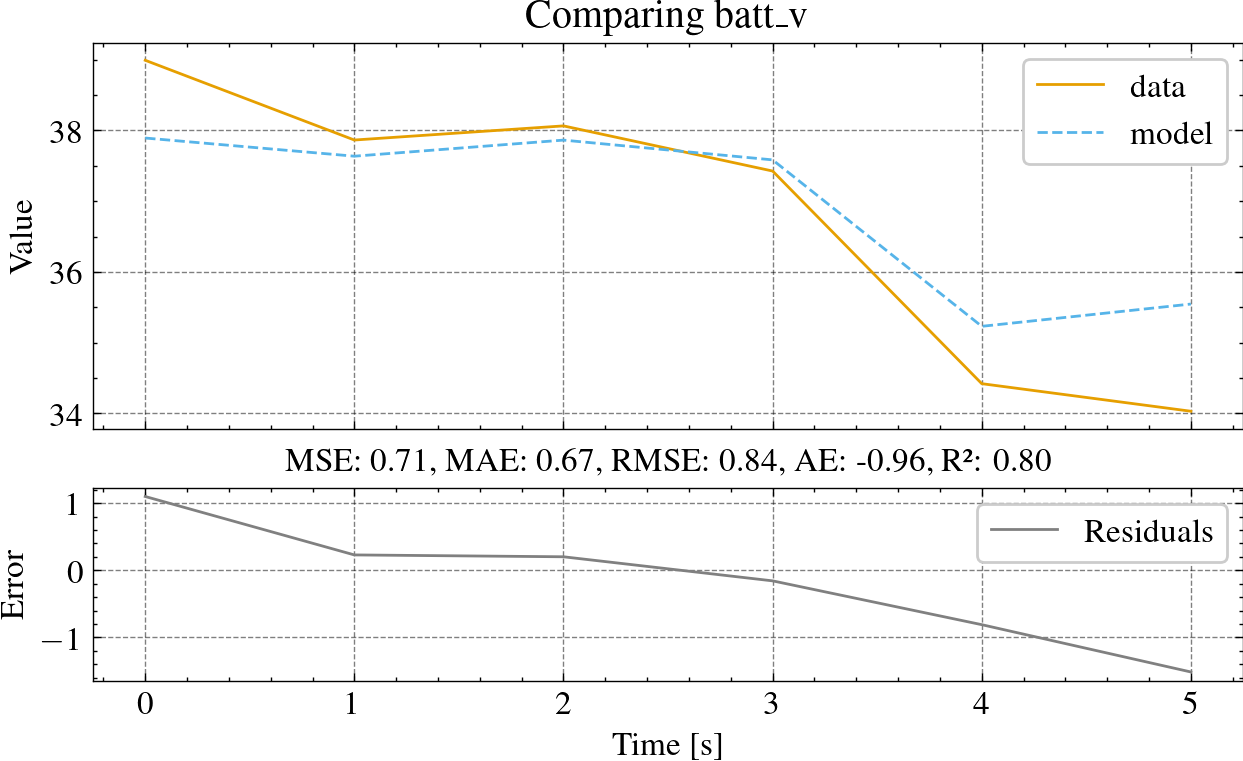

CPU times: user 2.93 s, sys: 2.25 s, total: 5.19 s
Wall time: 34.2 s


In [14]:
%%time

def run_battery_optimization(
    model,
    model_params,
    df,
    train_section,
    nominal_Q,
    series_cells,
    model_function,
    initial_SOC
):
    """
    Run the battery optimization with a hyperparameterized initial_SOC.
    (Implementation as provided in your code snippet)
    """
    # Define optimization and input data columns
    # data_cols = ['batt_v', 'batt_i', 'motor_w']
    data_cols = ['batt_v']
    input_cols = ['pv_g', 'pilot_d']

    # Extract and resample training data
    df_train = df.loc[
        (df.index >= train_section['start']) & (df.index <= train_section['end']),
        ['t'] + data_cols + input_cols  + ['batt_i']
    ].resample('1s').mean().interpolate(method='time')

    # Compute battery capacity and SOC using the hyperparameter initial_SOC
    compute_df_capacity(df_train, nominal_Q, initial_SOC, inplace=True)
    compute_df_soc(df_train, nominal_Q, inplace=True)
    # Optionally adjust batt_z (if needed)
    # df_train['batt_z'] = df_train['batt_z'] - df_train['batt_z'].min()

    # Set model state initial conditions
    input_initial_state = {
        'batt_z': df_train['batt_z'].iloc[0]
    }

    # Initialize parameter bounds for the optimization
    params_bounds = {
        'batt_R_0': dict(min=1e-3, max=1),
        'batt_R_1': dict(min=1e-3, max=1),
        'batt_C_1': dict(min=1, max=1e6),
    }
    poly_coeffs = [
        # {'name': 'batt_k_V_OC_coeffs', 'n_coeffs': 2, 'x_interval': (0, 1), 'y_bounds': (0.5*10.5, 2*13.5)},
    ]
    for coeff in poly_coeffs:
        name = coeff['name']
        n_coeffs = coeff['n_coeffs']
        y_bounds = coeff['y_bounds']
        coeff_bounds = estimate_polynomial_coefficient_bounds(
            x_interval=(0, 1), y_bounds=y_bounds, degree=(n_coeffs - 1)
        )
        for i in range(n_coeffs):
            params_bounds[f'{name}_{i}'] = dict(min=coeff_bounds[i][0], max=coeff_bounds[i][1])

    # Initialize the multiprocessing pool and parallel runner
    n_processes = 32
    pool = Pool(processes=n_processes)
    runner = StarmapParallelization(pool.starmap)

    # Set up the optimization problem
    problem = MyOptimizationProblem(
        model=model,
        model_function=model_function,
        training_data=df_train,
        training_data_columns=data_cols,
        model_params=model_params,
        opt_params_bounds=params_bounds,
        input_initial_state=input_initial_state,
        input_columns=input_cols,
        data_scaler=MinMaxScaler,
        elementwise_runner=runner,
    )

    # Configure the optimization algorithm (Differential Evolution)
    algorithm = DE(
        pop_size=20 * len(params_bounds),
        sampling=LHS(),
        variant="DE/rand/1/bin",
        F=0.5,
        CR=0.9,
    )

    # Set termination criteria
    termination = DefaultSingleObjectiveTermination(
        xtol=1e-8,
        cvtol=1e-6,
        ftol=1e-6,
        period=20,
        n_max_gen=1000,
        n_max_evals=100000,
    )

    # Run the battery optimization
    result = minimize(
        problem,
        algorithm,
        termination=termination,
        seed=42,
        verbose=True,
        save_history=True,
    )

    pool.close()
    pool.join()

    return result, params_bounds

model = SolarBoat
model_params = solar_boat_params.copy()
result, params_bounds = run_battery_optimization(
    model=model,
    model_params=model_params,
    df=df,
    train_section=train_section,
    nominal_Q=nominal_Q,
    series_cells=series_cells,
    model_function=model_function,
    initial_SOC=initial_SOC,
)

# Retrieve and display the best parameters
best_params = convert_to_model_params({k: result.X[i] for i, k in enumerate(params_bounds.keys())})
original_params = {k: convert_to_model_params(model_params)[k] for k in best_params.keys()}
print("Original parameters were:")
display(original_params)
print("Best parameters found:")
display(best_params)
print("Objective value at solution:", result.F)

# Plot optimization results
plot_optimization_params(result, params_bounds)
plot_optimization_error(result, params_bounds)

# Simulate the model with the optimized parameters
df_train = df.loc[
    (df.index >= train_section['start']) & (df.index <= train_section['end']),
    ['t'] + data_cols + input_cols
].resample('1s').mean().interpolate(method='time')
T = df_train['t'].to_numpy()
U = df_train[input_cols].to_numpy().T
X0 = SolarBoat.initial_state(
    X0={'batt_z': initial_SOC[0]},
    U0=U[:, 0],
    params=model_params | best_params
)
best_fit_data = model_function(T, U, X0, **(model_params | best_params))

# Plot the comparison for each data column
for col in data_cols:
    plot_compare(df_train, best_fit_data, col)

In [15]:
if 'batt_k_V_OC_coeffs' in best_params:
    soc_test = np.linspace(0, 1, 100)
    ocv_ref = np.polynomial.Polynomial(solar_boat_params['batt_k_V_OC_coeffs'])(soc_test)
    plt.plot(soc_test, ocv_ref, label='original')

    best_ocv_coeffs = best_params['batt_k_V_OC_coeffs']
    ocv_ref = np.polynomial.Polynomial(best_ocv_coeffs)(soc_test)
    plt.plot(soc_test, ocv_ref, label='best')
    plt.legend()
    plt.show()

In [16]:
%%time

import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.termination import get_termination
from pymoo.core.evaluator import Evaluator
from pymoo.parallelization.starmap import StarmapParallelization
from sklearn.metrics import mean_squared_error
import multiprocessing

class BattZOptimization(ElementwiseProblem):
    def __init__(self, section, df, nominal_Q, model_params, best_params, data_cols, input_cols, **kwargs):
        super().__init__(n_var=1, n_obj=1, n_constr=0, xl=np.array([0]), xu=np.array([1]), **kwargs)
        self.section = section
        self.df = df
        self.nominal_Q = nominal_Q
        self.model_params = model_params
        self.best_params = best_params
        self.data_cols = data_cols
        self.input_cols = input_cols

    def _evaluate(self, x, out, *args, **kwargs):
        batt_z_0 = x[0]

        df_test = self.df.loc[
            (self.df.index >= self.section['start']) & (self.df.index <= self.section['end']),
            ['t'] + self.data_cols + self.input_cols + ['batt_i']
        ].dropna().resample('1s').mean().interpolate(method='time')

        if df_test.empty:
            out["F"] = np.inf
            return

        compute_df_capacity(df_test, self.nominal_Q, batt_z_0, inplace=True)
        compute_df_soc(df_test, self.nominal_Q, inplace=True)

        T = df_test['t'].to_numpy()
        U = df_test[self.input_cols].to_numpy().T

        X0 = SolarBoat.initial_state(X0={'batt_z': df_test['batt_z'][0]}, U0=U[:, 0], params=self.model_params | self.best_params)
        df_pred = model_function(T, U, X0, **(self.model_params | self.best_params))

        out["F"] = mean_squared_error(df_test[self.data_cols].values, df_pred[self.data_cols].values)

# Create a parallel processing pool
n_processes = 32
pool = Pool(processes=n_processes)
runner = StarmapParallelization(pool.starmap)

model_params = solar_boat_params.copy()

# Run optimization for each section
batt_z_0_dict = {}
for section in sections.reset_index().to_dict(orient='records'):
    section_name = section['name'].replace('Section ', '')

    problem = BattZOptimization(
        section, df, nominal_Q, model_params, best_params, data_cols, input_cols, elementwise_runner=runner,
    )

    algorithm = DE(
        pop_size=10,
        sampling=LHS(),
        variant="DE/rand/1/bin",
        F=0.5,
        CR=0.9,
    )
    # algorithm = NelderMead()

    termination = DefaultSingleObjectiveTermination(
        xtol=1e-8,
        cvtol=1e-6,
        ftol=1e-6,
        period=20,
        n_max_gen=10000,
        n_max_evals=100000
    )

    res = minimize(problem, algorithm, termination=termination, seed=42, verbose=True, save_history=True)

    batt_z_0_dict[section_name] = res.X[0]

    print(f'Optimized batt_z_0 for {section_name}: {res.X[0]}')

pool.close()
pool.join()

print("Final batt_z_0_dict:", batt_z_0_dict)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 |  1.972941E+01 |  1.685013E+01
     2 |       20 |  1.811973E+01 |  1.652207E+01
     3 |       30 |  1.749875E+01 |  1.652207E+01
     4 |       40 |  1.716542E+01 |  1.652207E+01
     5 |       50 |  1.691985E+01 |  1.652207E+01
     6 |       60 |  1.678644E+01 |  1.652207E+01
     7 |       70 |  1.664627E+01 |  1.642397E+01
     8 |       80 |  1.660247E+01 |  1.642397E+01
     9 |       90 |  1.657273E+01 |  1.642397E+01
    10 |      100 |  1.655489E+01 |  1.642397E+01
    11 |      110 |  1.654903E+01 |  1.642397E+01
    12 |      120 |  1.653979E+01 |  1.642397E+01
    13 |      130 |  1.653979E+01 |  1.642397E+01
    14 |      140 |  1.652348E+01 |  1.642397E+01
    15 |      150 |  1.652348E+01 |  1.642397E+01
    16 |      160 |  1.652348E+01 |  1.642397E+01
    17 |      170 |  1.652348E+01 |  1.642397E+01
    18 |      180 |  1.651969E+01 |  1.642397E+01
    19 |      190 |  1.651969E+01 |  1.642397E+01


{'D': 0.5225256204927032, 'E': 0.007874439724701154, 'F': 0.6727370471600884, 'F1': 0.3474188817876604, 'F2': 0.33767636441198434}
/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//battery_optimization_test_residuals_batt_v_test_d.pdf


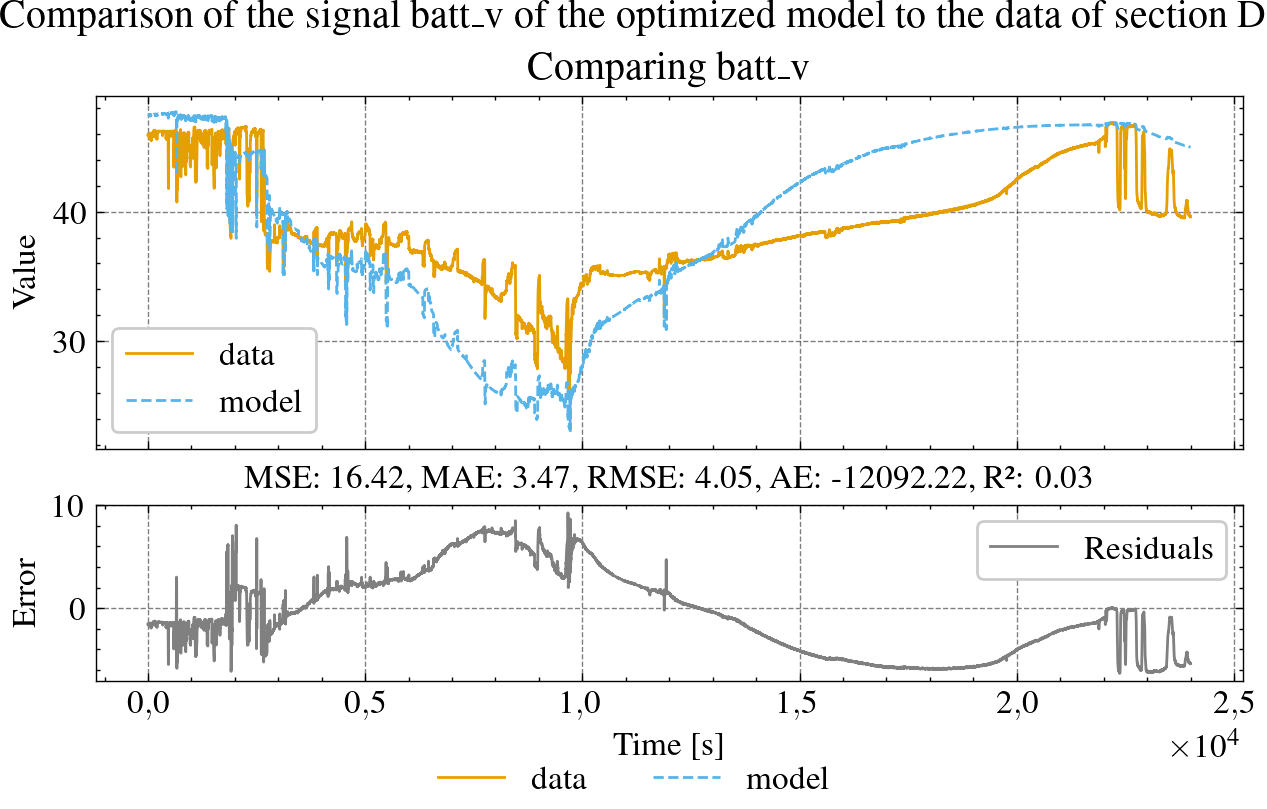

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//battery_optimization_test_residuals_batt_v_test_e.pdf


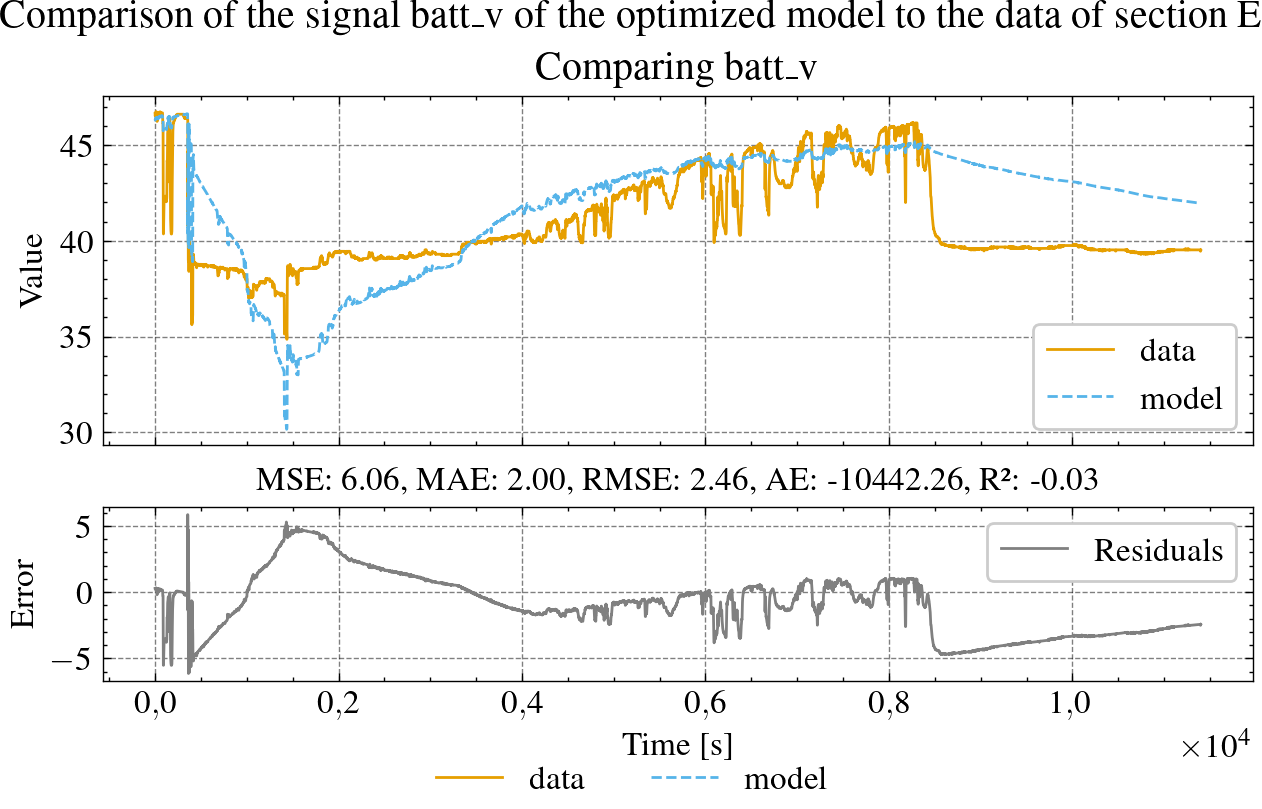

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//battery_optimization_test_residuals_batt_v_test_f.pdf


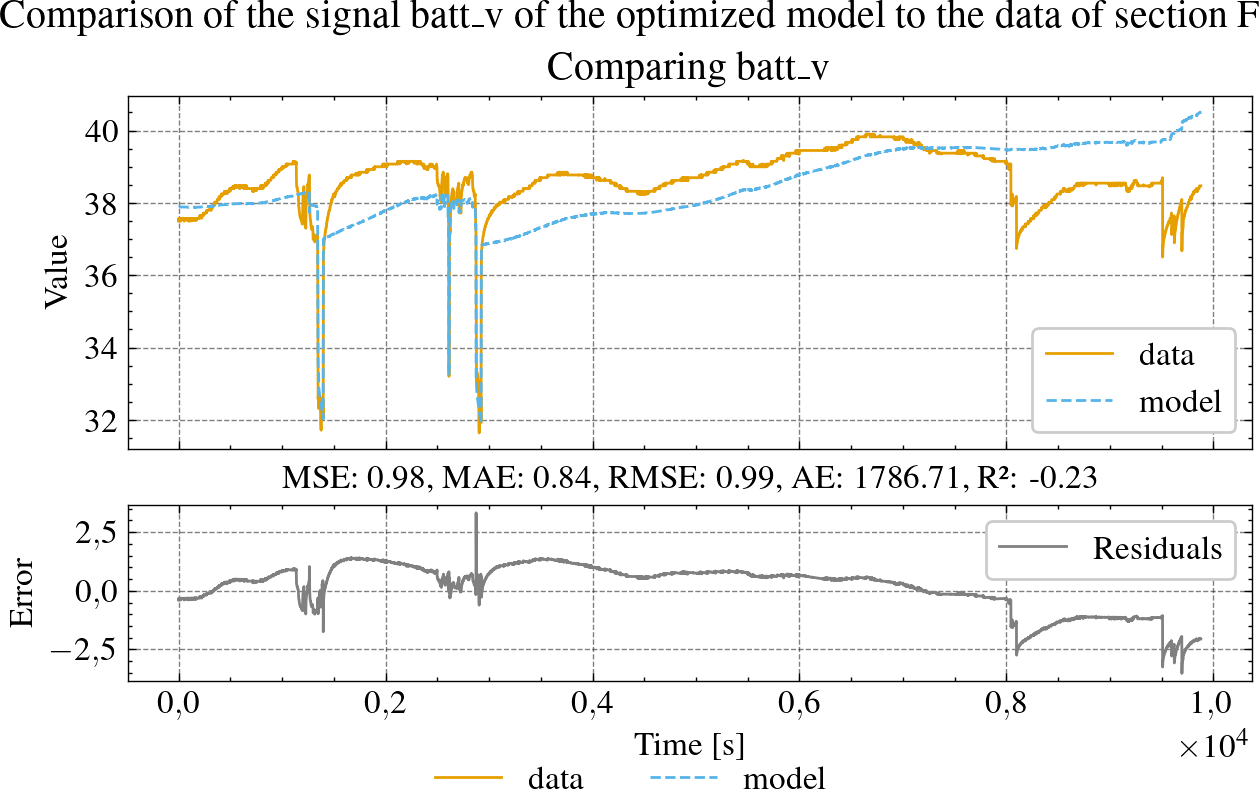

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//battery_optimization_test_residuals_batt_v_test_f1.pdf


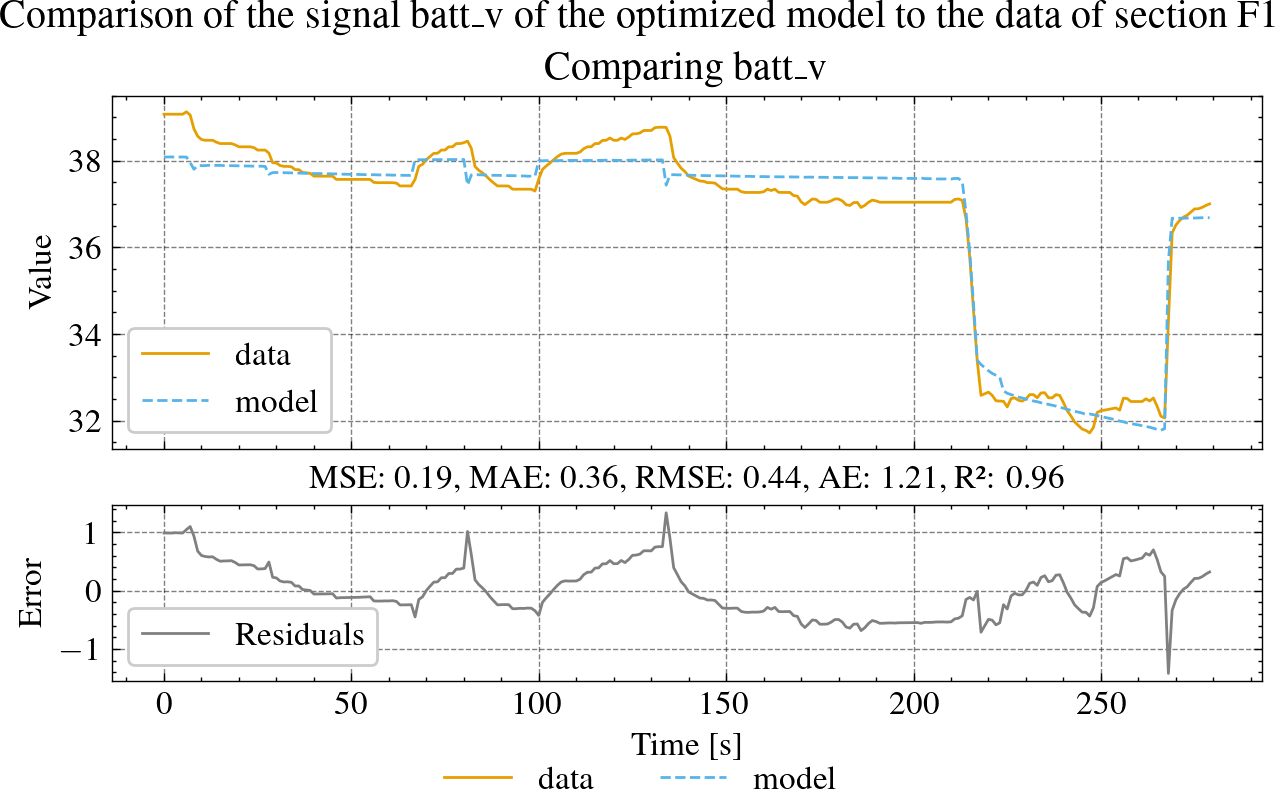

/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs//battery_optimization_test_residuals_batt_v_test_f2.pdf


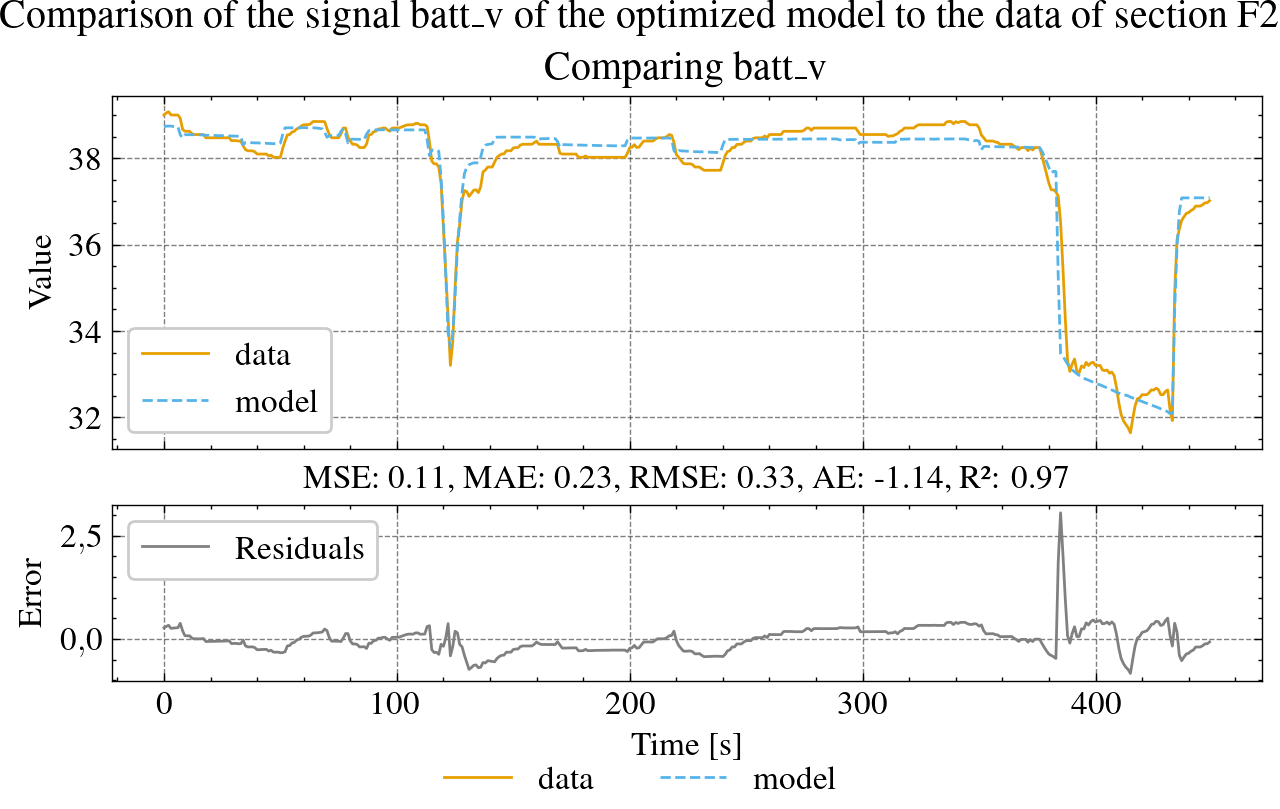

In [24]:
print(batt_z_0_dict)

for section in sections.reset_index().to_dict(orient='records'):
    section_name = section['name'].replace('Section ', '')
    batt_z_0 = batt_z_0_dict[section_name]

    df_test = df.loc[(df.index >= section['start']) & (df.index <= section['end']), ['t'] + data_cols + input_cols + ['batt_i']].dropna()
    if df_test.size == 0:
        print('Ignoring section', section_name, ' because of insufficient size')
        continue
    compute_df_capacity(df_test, nominal_Q, batt_z_0, inplace=True)
    compute_df_soc(df_test, nominal_Q, inplace=True)
    batt_z_0 = df_test['batt_z'][0]

    T = df_test['t'].to_numpy()
    U = df_test[input_cols].to_numpy().T
    X0 = SolarBoat.initial_state(X0={'batt_z': batt_z_0}, U0=U[:,0], params=model_params | best_params)

    df_pred = model_function(T, U, X0, **(model_params | best_params))

    # Plot comparison for each data column
    for col in data_cols:
        filename = f'{latex_img_path}/battery_optimization_test_residuals_{col}_test_{section_name.lower()}.pdf'
        print(filename)
        fig_save_and_show(
            filename=filename,
            show_title=f'Comparison of the signal {col} of the optimized model to the data of section {section_name}',
            save_title=f'Comparação do sinal {col} do modelo otimizado com os dados da seção {section_name}',
            ncol=2,
            fig=plot_compare(df_test, df_pred, col, show=False),
        )


In [21]:
# input_initial_state = {
#     'batt_z': df_train['batt_z'].iloc[0]
# }

# # Initialize a list to store metrics
# metrics_list = []
# for section in sections.reset_index().to_dict(orient='records'):
#     section_name = section['name'].replace('Section ', '')

#     # Select the data and simulate
#     df_test = df.loc[(df.index >= section['start']) & (df.index <= section['end']), ['t'] + data_cols + input_cols].dropna()
#     if df_test.size == 0:
#         print('Ignoring section', section_name, ' because of insufficient size')
#         continue

#     # Simulate
#     T = df_test['t'].to_numpy()
#     U = df_test[input_cols].to_numpy().T
#     X0 = model.initial_state(X0=input_initial_state, U0=U[:,0], params=model_params | best_params)

#     df_pred = model_function(T, U, X0, **(solar_boat_params | best_params))

#     # Compute metrics for each data column
#     for col in data_cols:
#         metrics = compute_metrics(df_test[col].to_numpy(), df_pred[col].to_numpy())
#         metrics['section'] = section_name
#         metrics['data'] = col

#         metrics_list.append(metrics)

# # Create a DataFrame from the metrics list
# df_metrics = pd.DataFrame(metrics_list).drop(columns=['residuals']).set_index(['section', 'data'])
# display(df_metrics)

# metrics_table_latex = df_metrics.to_latex(
#     index=True,
#     caption="Métricas de avaliação do modelo da Geração",
#     label="table:battery_optimization_metrics_table",
#     float_format="%.2f",
#     column_format="l|l" + "|c" * (len(df_metrics.columns)),
#     escape=True,
#     decimal=',',
#     position='h!',
#     multicolumn=True,
# ).replace('\\toprule', '\\hline').replace('\\bottomrule\n', '').replace('\\midrule', '\\hline').replace('\\end{table}', '\\fonte{Elaboração Própria (\\the\\year)}\n\\end{table}')

# with open(f"{latex_tex_path}/battery_optimization_metrics_table.tex", "w") as f:
#     f.write(metrics_table_latex)

# for section in sections.reset_index().to_dict(orient='records'):
#     section_name = section['name'].replace('Section ', '')

#     df_test = df.loc[(df.index >= section['start']) & (df.index <= section['end']), ['t'] + data_cols + input_cols].dropna()
#     if df_test.size == 0:
#         print('Ignoring section', section_name, ' because of insufficient size')
#         continue

#     # Simulate
#     T = df_test['t'].to_numpy()
#     U = df_test[input_cols].to_numpy().T
#     X0 = model.initial_state(X0=input_initial_state, U0=U[:,0], params=model_params | best_params)

#     df_pred = model_function(T, U, X0, **(solar_boat_params | best_params))

#     # Plot comparison for each data column
#     for col in data_cols:
#         filename = f'{latex_img_path}/battery_optimization_test_residuals_{col}_test_{section_name.lower()}.pdf'
#         print(filename)
#         fig_save_and_show(
#             filename=filename,
#             show_title=f'Comparison of the signal {col} of the optimized model to the data of section {section_name}',
#             save_title=f'Comparação do sinal {col} do modelo otimizado com os dados da seção {section_name}',
#             ncol=2,
#             fig=plot_compare(df_test, df_pred, col, show=False),
#         )
